In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout

from scipy.sparse import coo_matrix

In [2]:
# Load the MovieLens dataset (download it from https://grouplens.org/datasets/movielens/)
file_path = '../data/ratings_filtered.csv'
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, names=columns).drop(0)
df.head(5)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3860\2276829136.py:4: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, names=columns).drop(0)


,user_id,movie_id,rating,timestamp
1,1,110,1.0,1425941529
2,1,147,4.5,1425942435
3,1,858,5.0,1425941523
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016557 entries, 1 to 11016557
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user_id    object
 1   movie_id   object
 2   rating     object
 3   timestamp  object
dtypes: object(4)
memory usage: 336.2+ MB


In [4]:
# Filter sparse movies
min_movie_ratings = 2000
filter_movies = (df['movie_id'].value_counts() > min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 100
filter_users = (df['user_id'].value_counts() > min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df[(df['movie_id'].isin(filter_movies)) & (df['user_id'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(11016557, 4)
Shape User-Ratings filtered:	(4747375, 4)


In [6]:
del df

In [5]:
# Shuffle DataFrame
df_filterd = df_filterd.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 3000000

# Split train- & testset
df_train = df_filterd[:-n]
df_test = df_filterd[-n:]

In [8]:
# Convert columns to integers
df_train['user_id'] = df_train['user_id'].astype(np.int64)
df_train['movie_id'] = df_train['movie_id'].astype(np.int64)
df_train['rating'] = df_train['rating'].astype(np.float64)

df_test['user_id'] = df_test['user_id'].astype(np.int64)
df_test['movie_id'] = df_test['movie_id'].astype(np.int64)
df_test['rating'] = df_test['rating'].astype(np.float64)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3860\3532336857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['user_id'] = df_train['user_id'].astype(np.int64)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3860\3532336857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['movie_id'] = df_train['movie_id'].astype(np.int64)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3860\3532336857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [10]:
user_item_matrix = df_train.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix.sample(3)

movie_id,2,3,5,6,11,12,14,15,16,17,...,94959,96821,97938,104211,104374,107406,110553,111759,115210,140174
user_id,,,,,,,,,,,,,,,,,,,,,
181806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147172,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147011,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filterd['user_id'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filterd['movie_id'].unique())}

# Create correctly mapped train- & testset
train_user_data = df_train['user_id'].map(user_id_mapping)
train_movie_data = df_train['movie_id'].map(movie_id_mapping)

test_user_data = df_test['user_id'].map(user_id_mapping)
test_movie_data = df_test['movie_id'].map(movie_id_mapping)

# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)

In [12]:
# Setup variables
user_embedding_size = 20
movie_embedding_size = 10


##### Create model deep learning with keras
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')

d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2024-1\Applications of Data Science\CC219-TP-TF-2024-1-CC92\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 20)     │    542,120 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 10)     │      9,570 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 20)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 10)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30)        │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      7,936 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 559,883 (2.14 MB)

 Trainable params: 559,883 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Fit model
history = model.fit([train_user_data, train_movie_data],
          df_train['rating'],
          batch_size=256, 
          epochs=10,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_movie_data])
y_true = df_test['rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With Keras Deep Learning: {:.4f} RMSE'.format(rmse))

Epoch 1/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1691 - val_loss: 0.7390
Epoch 2/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7237 - val_loss: 0.7294
Epoch 3/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.7151 - val_loss: 0.7258
Epoch 4/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7116 - val_loss: 0.7253
Epoch 5/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7089 - val_loss: 0.7225
Epoch 6/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7070 - val_loss: 0.7256
Epoch 7/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7048 - val_loss: 0.7226
Epoch 8/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7077 - val_loss: 0.7218
Epoch 9/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.7039 - val_loss: 0.7250
Epoch 10/10
6144/6144 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7026 - val_loss: 0.7212
93750/93750 ━━━━━━━━━━━━━━━━━━━━ 67s 709us/step


Testing Result With Keras Deep Learning: 0.8477 RMSE


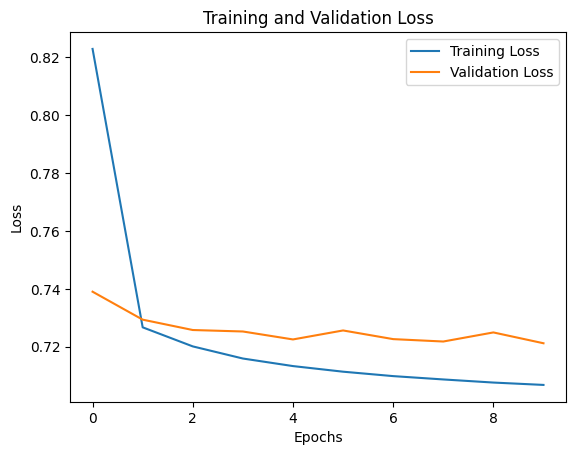

In [15]:
# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Create a map with key as movieId and value as index in user_item_matrix_binary
movieId_to_index = {}
index_to_movieId = {}
for index, movieId in enumerate(user_item_matrix_binary.columns):
    movieId_to_index[movieId] = index
    index_to_movieId[index] = movieId

In [ ]:
def generate_recommendations(rbm, user_watched_movies, num_movies, num_recommendations=20):
    # Initialize the user vector
    new_user_vector = np.zeros((1, num_movies))
    for movie_id, rating in user_watched_movies.items():
        index = movieId_to_index[movie_id]
        new_user_vector[0, index] = rating > 0
    
     # Predict the user's preferences
    reconstructed_user_vector = rbm.predict(new_user_vector)
    #print(reconstructed_user_vector)
    #for movie_id, rating in user_watched_movies.items():
    #    index = movieId_to_index[movie_id]
    #    reconstructed_user_vector[0, index] = 0
    #print(reconstructed_user_vector)
    #print(np.argsort(reconstructed_user_vector[0]))
    #print(reconstructed_user_vector[0][movieId_to_index[175331]])
    #print(reconstructed_user_vector[0][movieId_to_index[296]])
    #print(reconstructed_user_vector[0][movieId_to_index[593]])
    #print(reconstructed_user_vector[0][movieId_to_index[2959]])
    recommended_indices = np.argsort(reconstructed_user_vector[0])[::-1][:num_recommendations]
    recommended_movie_ids = [index_to_movieId[index] for index in recommended_indices]

    #recommendations = np.argsort(reconstructed_user_vector[0])[-num_recommendations:][::-1]
    
    return recommended_movie_ids

In [75]:
# Example: Recommend items for a specific user
user_id = 1  # Replace with the desired user ID
user_representation = y_pred[user_id - 1]

# Calculate the predicted ratings for all items
predicted_ratings = np.dot(y_pred, user_representation)

# Display top N recommendations
top_n = np.argsort(predicted_ratings)[::-1][:10]
print(f"Top recommendations for User {user_id}: {top_n + 1}")

Top recommendations for User 1: [82570 14818 35293 20158  5464 71482 81883 13954 75371 56121]


In [79]:
# Save the model
model.save('embeddings.h5')
# Save the weights of the model
model.save_weights('embeddings.weights.h5')

# Save the model as JSON
model_json = model.to_json()
with open("embeddings_model.json", "w") as json_file:
    json_file.write(model_json)